# **IMPUTACION ESPACIOTEMPORAL DE SERIES DE PRECIPITACION**
En este notebook se realiza la imputacion de datos en la serie de precipitacion del CCCP con series de precipitacion de la base de datos de CHIRPS  para poder tener una serie continua, se utilizan modelos estacionarios como SARIMA

## **Proceso ETL**
---
## 1. Datos de la Red MPOMM
- Obtencion de los datos de la serie de precipitaicond e la base de datos de Red_MPOMM

In [1]:
from api_somo import DataFetcher, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2010-01-01",
    "end_date":"2012-12-31"
    }

try:
    # 1. Fetch and process the data
    red_mpomm_serie = DataFetcher.fetch_and_process_data(api_url, params)

    if red_mpomm_serie.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {red_mpomm_serie.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


display(red_mpomm_serie)

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2010-01-01', 'end_date': '2012-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag', 'latitude', 'longitude']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf', 'latitude', 'longitude']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf, latitude, longitude]
Index: []


,value,qf,latitude,longitude
timestamp,,,,
2010-01-01 05:00:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:10:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:20:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:30:00+00:00,0.0,1,1.82011,-78.72871
2010-01-01 05:40:00+00:00,0.0,1,1.82011,-78.72871
...,...,...,...,...
2012-12-31 04:20:00+00:00,0.1,1,1.82011,-78.72871
2012-12-31 04:30:00+00:00,0.0,1,1.82011,-78.72871
2012-12-31 04:40:00+00:00,0.1,1,1.82011,-78.72871


In [2]:
from graphics_utils.express import fig_pie_month
pie_fig = fig_pie_month(red_mpomm_serie, params)
pie_fig.show()

### ETL-Red MPOMM
- Preprocesamiento de los datos de la redmpomm

- Se convierten a nan los datos que tienen bandera de calidad distinta de 'bueno' y se realiza un reporte de cuantos datos nulos quedaron

In [3]:
import numpy as np
red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3]), 'value'] = np.nan
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
red_mpomm_serie.isnull().sum()

value        13089
qf               0
latitude         0
longitude        0
month            0
year             0
dtype: int64

- Se realiza un remuestreo con la funcion predeterminada, y se vuelve a remplazar con nan los datos que tengan calidad distinta a 'bueno'

In [4]:
from utils.utils import reshample_time_serie
serie_resample=reshample_time_serie(red_mpomm_serie, nueva_frecuencia='D', metodo='sum')
display(serie_resample.columns)
# Aplicar la condición para reemplazar 'value' con NaN si 'qf' no es 1
serie_resample['value'] = serie_resample['value'].where(serie_resample['qf'] == 1, np.nan)
serie_resample


Index(['value', 'qf', 'latitude', 'longitude', 'month', 'year'], dtype='object')

,value,qf,latitude,longitude,month,year
timestamp,,,,,,
2010-01-01,0.0,1,1.82011,-78.72871,1,2010
2010-01-02,0.0,1,1.82011,-78.72871,1,2010
2010-01-03,4.1,1,1.82011,-78.72871,1,2010
2010-01-04,0.4,1,1.82011,-78.72871,1,2010
2010-01-05,0.3,1,1.82011,-78.72871,1,2010
...,...,...,...,...,...,...
2012-12-27,0.0,1,1.82011,-78.72871,12,2012
2012-12-28,0.0,1,1.82011,-78.72871,12,2012
2012-12-29,0.0,1,1.82011,-78.72871,12,2012


- Muestra la cantidad de Nan en el dataset
- Crear el dataset de trabajo

In [5]:
import pandas as pd

dataset = serie_resample['value'].to_frame()

display(dataset.isnull().sum())

# Mostrar el resultado
display(dataset)



value    175
dtype: int64

,value
timestamp,
2010-01-01,0.0
2010-01-02,0.0
2010-01-03,4.1
2010-01-04,0.4
2010-01-05,0.3
...,...
2012-12-27,0.0
2012-12-28,0.0
2012-12-29,0.0


## 2. Datos de CIRPS

### Obtener los datos del data warehouse
- En este df se extraen los datos mas cercanos al punto al cual se le realiza la imputacion, la inspeccion fue visual para determinar dichos puntos 

In [6]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure
import pandas as pd

try:
    # Conexión a MongoDB
    print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['sensor_data']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in df.columns:
            df = df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        df = df[df['point_id'].isin(selected_points)]

        # Mostrar las primeras filas del DataFrame
        print("DataFrame creado con éxito:")
        display(df.head(5))

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


Intentando conectar a MongoDB...
Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
DataFrame creado con éxito:


,point_id,latitude,longitude,value,timestamp
5,point_6,1.774998,-78.725006,0.000000,2009-02-01
9,point_10,1.824997,-78.725006,0.000000,2009-02-01
11,point_12,1.824997,-78.775000,0.000000,2009-02-01
17,point_6,1.774998,-78.725006,0.000000,2009-02-02
21,point_10,1.824997,-78.725006,12.457714,2009-02-02


### ETL-CHIRPS
- Transformacion del formato, se extraen las series temporales continuas y que coinciden con la marca de tiempo, esto se realiza para obtener el formato para añadir al dataset de trabajo

In [7]:
import pandas as pd

# Suponiendo que df es tu dataset original
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Asegurar que sea datetime

# Crear la tabla pivotante con fecha como índice y cada punto como columna
df_pivot = df.pivot_table(index='timestamp', columns='point_id', values='value')

# Mostrar el DataFrame resultante
display(df_pivot)



point_id,point_10,point_12,point_6
timestamp,,,
2009-02-01,0.000000,0.000000,0.000000
2009-02-02,12.457714,16.109703,0.000000
2009-02-03,12.457714,16.109703,29.260645
2009-02-04,0.000000,0.000000,0.000000
2009-02-05,0.000000,0.000000,0.000000
...,...,...,...
2022-12-28,0.000000,0.000000,7.627149
2022-12-29,0.000000,0.000000,0.000000
2022-12-30,0.000000,0.000000,11.136356


- Se filtran y vuelven nan los datos que superan el umbral 

In [8]:
# Reemplazar los valores mayores a 500 por NaN
df_pivot = df_pivot.mask(df_pivot > 500)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
df_pivot.isnull().sum()


point_id
point_10    1
point_12    0
point_6     6
dtype: int64

## **Analisis de los datos**
---
### Dataset
- Se añade al dataset los datos de CHIRPS y se calcula las dimenciones del dataset

In [9]:
# Convertir el índice de df_pivot a naive (sin zona horaria)
df_pivot.index = df_pivot.index.tz_localize(None)

# Si dataset también tiene una columna de fecha, conviértela a datetime sin zona horaria
dataset.index = pd.to_datetime(dataset.index).tz_localize(None)

# Intentar unir los DataFrames nuevamente
dataset = dataset.join(df_pivot, how='inner')
display(dataset.shape)
dataset


(1096, 4)

,value,point_10,point_12,point_6
timestamp,,,,
2010-01-01,0.0,0.0000,0.000000,0.000000
2010-01-02,0.0,0.0000,0.000000,0.000000
2010-01-03,4.1,0.0000,0.000000,0.000000
2010-01-04,0.4,0.0000,0.000000,0.000000
2010-01-05,0.3,0.0000,0.000000,0.000000
...,...,...,...,...
2012-12-27,0.0,0.0000,0.000000,0.000000
2012-12-28,0.0,0.0000,0.000000,0.000000
2012-12-29,0.0,0.0000,0.000000,0.000000


### Graficar las series temporales
- Se grafican las series del dataset para tener una vision general del comportamiento de cada una

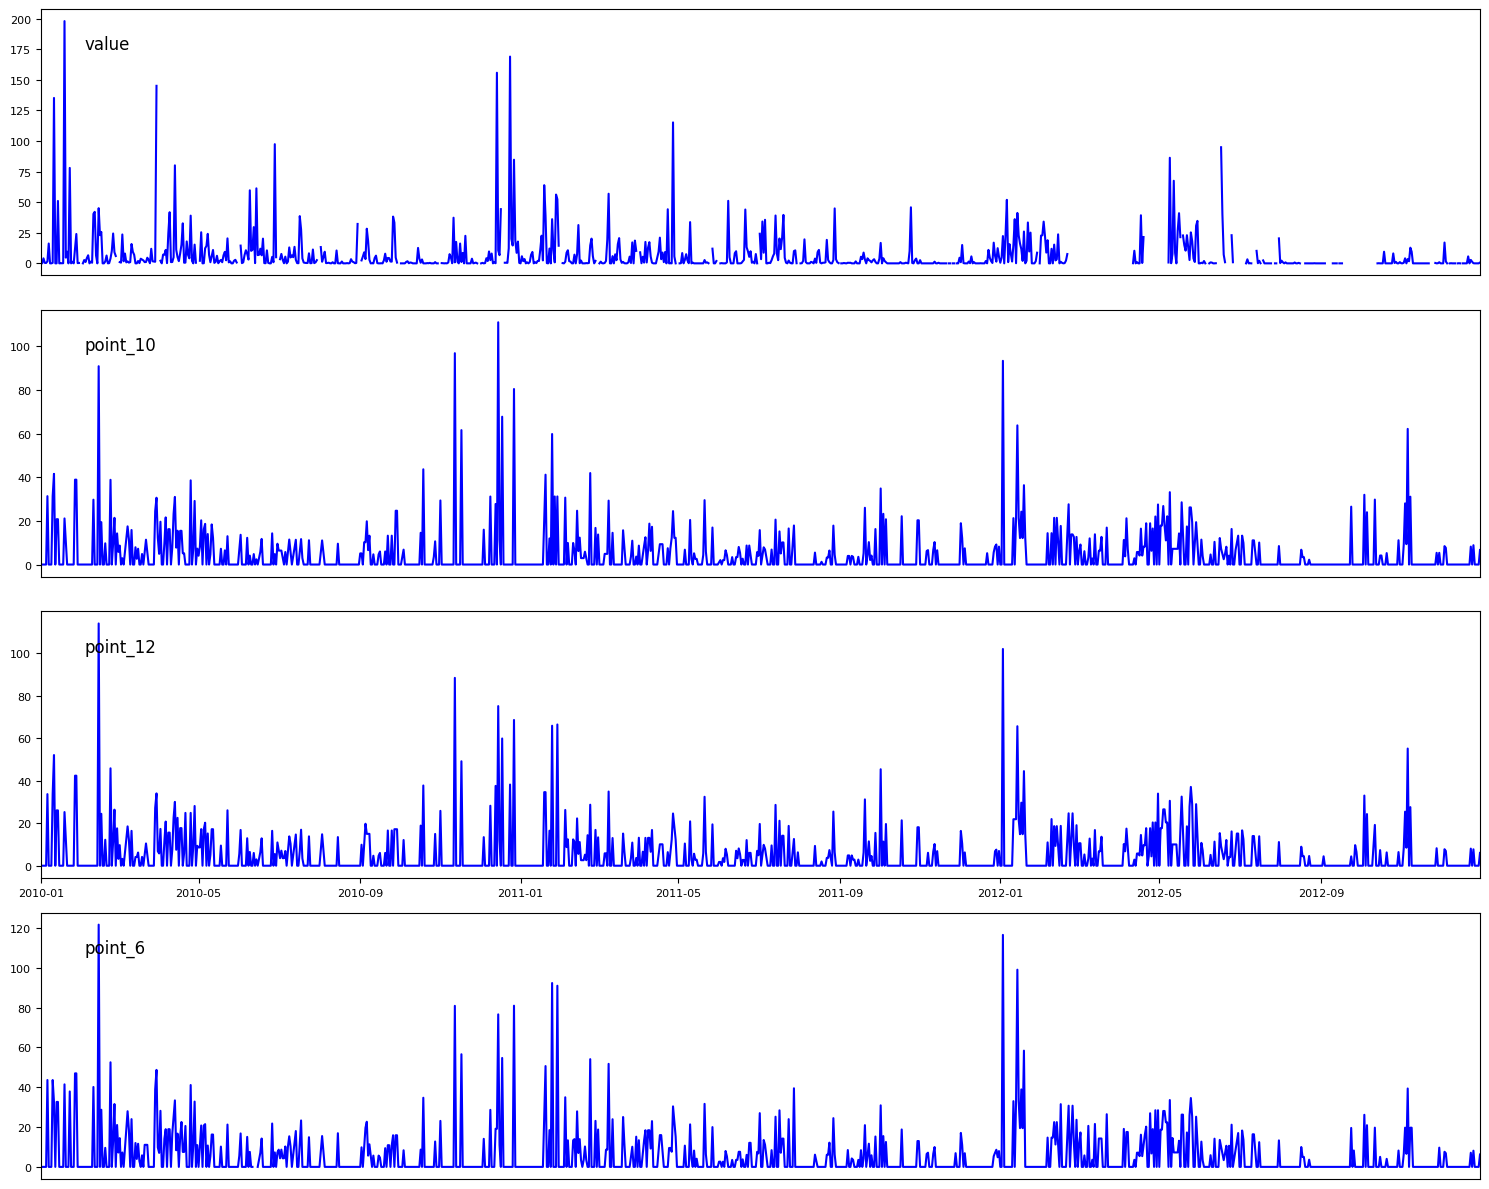

In [10]:
import matplotlib.pyplot as plt
# Gráficar
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(dataset.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset.index, dataset[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset.index.min(), dataset.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
    if i != len(dataset.columns[1:]) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('', fontsize=6)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

### Grafico espacial
- estracion de coordenadas.

Se extraen las coordenadas de mongo y de la serie de la red mpomm de manera dinamica.

In [11]:
# Extraer las ubicaciones únicas
locations_df = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Convertir red_mpomm_serie[0] en un DataFrame (si no lo es)
new_locations = pd.DataFrame(red_mpomm_serie[['latitude', 'longitude']].drop_duplicates())

# Concatenar ambos DataFrames y eliminar duplicados
locations_df = pd.concat([locations_df, new_locations]).drop_duplicates().reset_index(drop=True)

# Mostrar el resultado
print(locations_df)



   latitude  longitude
0  1.774998 -78.725006
1  1.824997 -78.725006
2  1.824997 -78.775000
3  1.820110 -78.728710


- Se crea el mapa y se grafican los puntos que estan disponibles

In [12]:
import folium

# Crear el mapa centrado en la ubicación promedio
map_center = [locations_df['latitude'].mean(), locations_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Agregar marcadores al mapa
for _, row in locations_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                popup=f"Lat: {row['latitude']}, Lon: {row['longitude']}").add_to(m)

# Mostrar el mapa (en un entorno compatible como Jupyter Notebook)
m


### Correlaciones entre los datos
- Ajustamos los datos eliminando los nan y garantizamos que la matriz sea cuadrada para su trabajo

In [13]:
# Crear un dataframe con solo las filas con datos en todas las columnas
dataset_no_nan = dataset.dropna()
dataset_no_nan.shape

(919, 4)

- grafico de las series continuas 

Inspeccion visual del estado de las series que se encuentran en el dataset ademas de un informe numerico para corroborar la inexistencia de registros nan.

value       0
point_10    0
point_12    0
point_6     0
dtype: int64

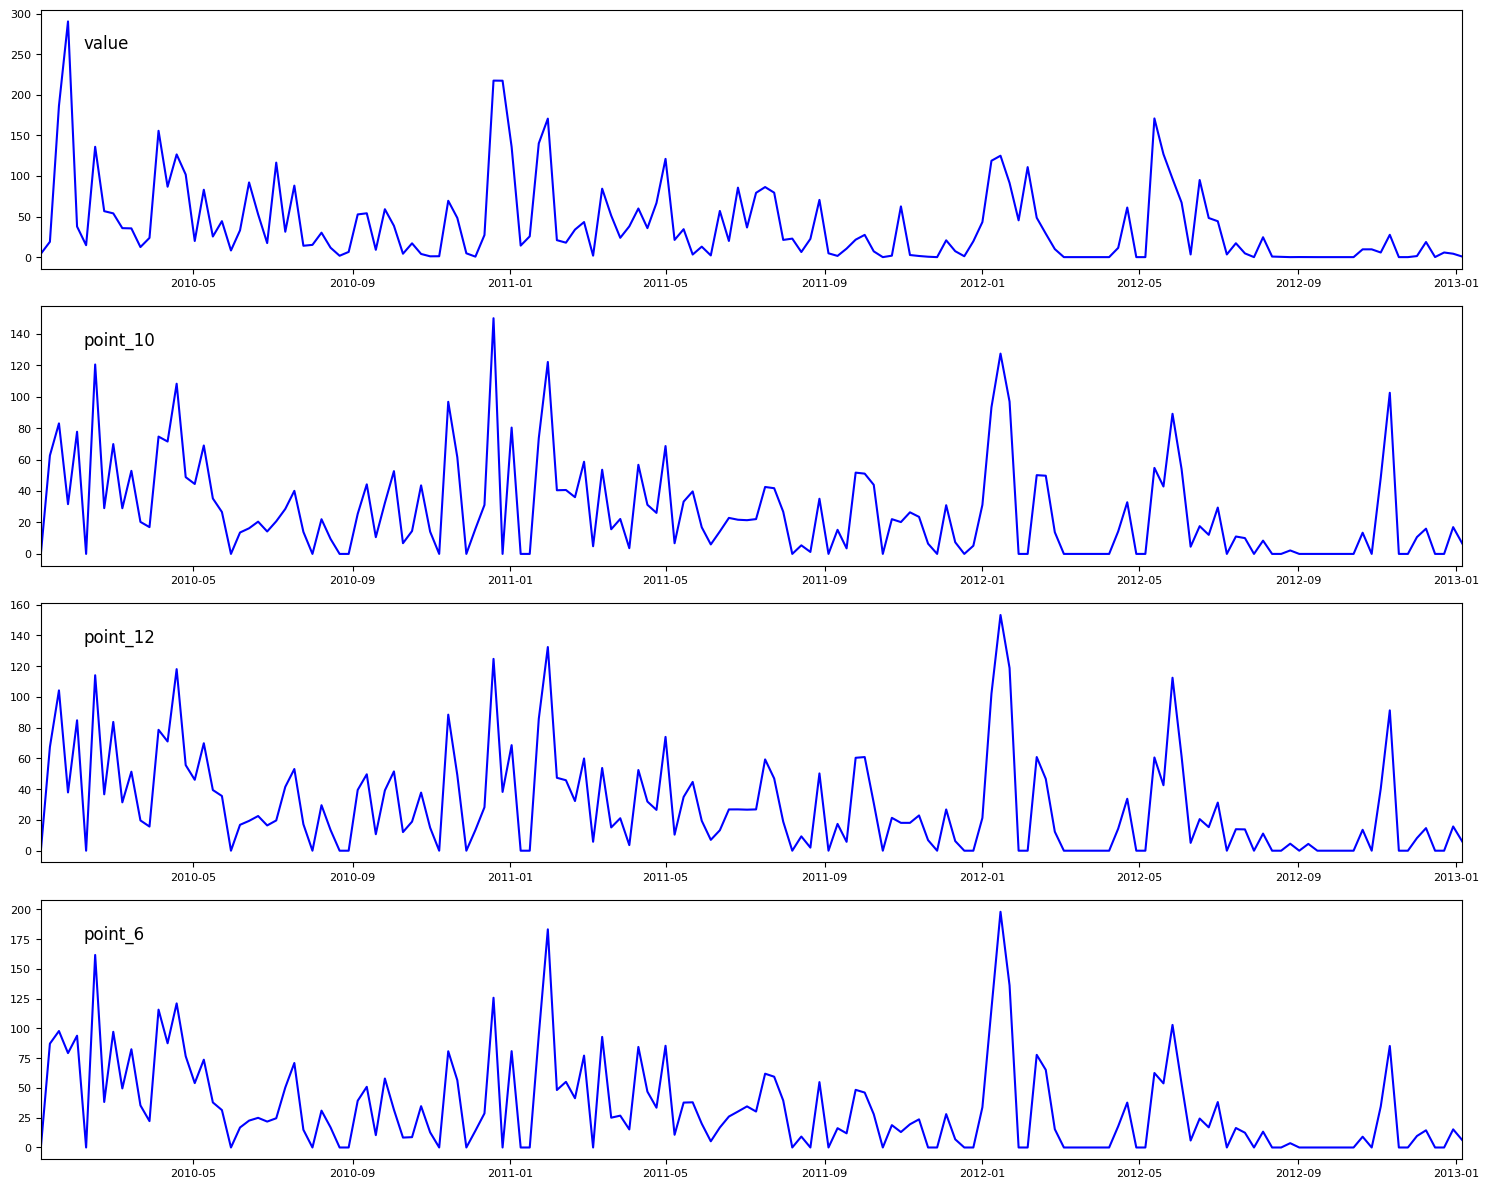

In [14]:

# Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos

display(dataset_no_nan.isnull().sum())

dataset_no_nan = dataset_no_nan.resample('W').sum()
# Filtrar solo los valores mayores que 0 en el DataFrame
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos > 0]
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos < 1500] # filtro que se coloca por unos datos sospechosos que se intentan comparar toman valores demasiado altos


# Gráficar
fig, axs = plt.subplots(nrows=dataset_no_nan.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(dataset_no_nan.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset_no_nan.index, dataset_no_nan[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset_no_nan.index.min(), dataset_no_nan.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

- Metodo numerico de correlaciones

Matriz que obtiene los valores cuantitativos de la correlacionde las series del dataset 

- Metodo grafico de correlaciones

Imagen de matriz de correlacion en la cual se aprecian tendencias outliyers y otra clase de informacion alterna de las series

,value,point_10,point_12,point_6
value,1.000000,0.637825,0.677514,0.681934
point_10,0.637825,1.000000,0.976929,0.952675
point_12,0.677514,0.976929,1.000000,0.964672
point_6,0.681934,0.952675,0.964672,1.000000


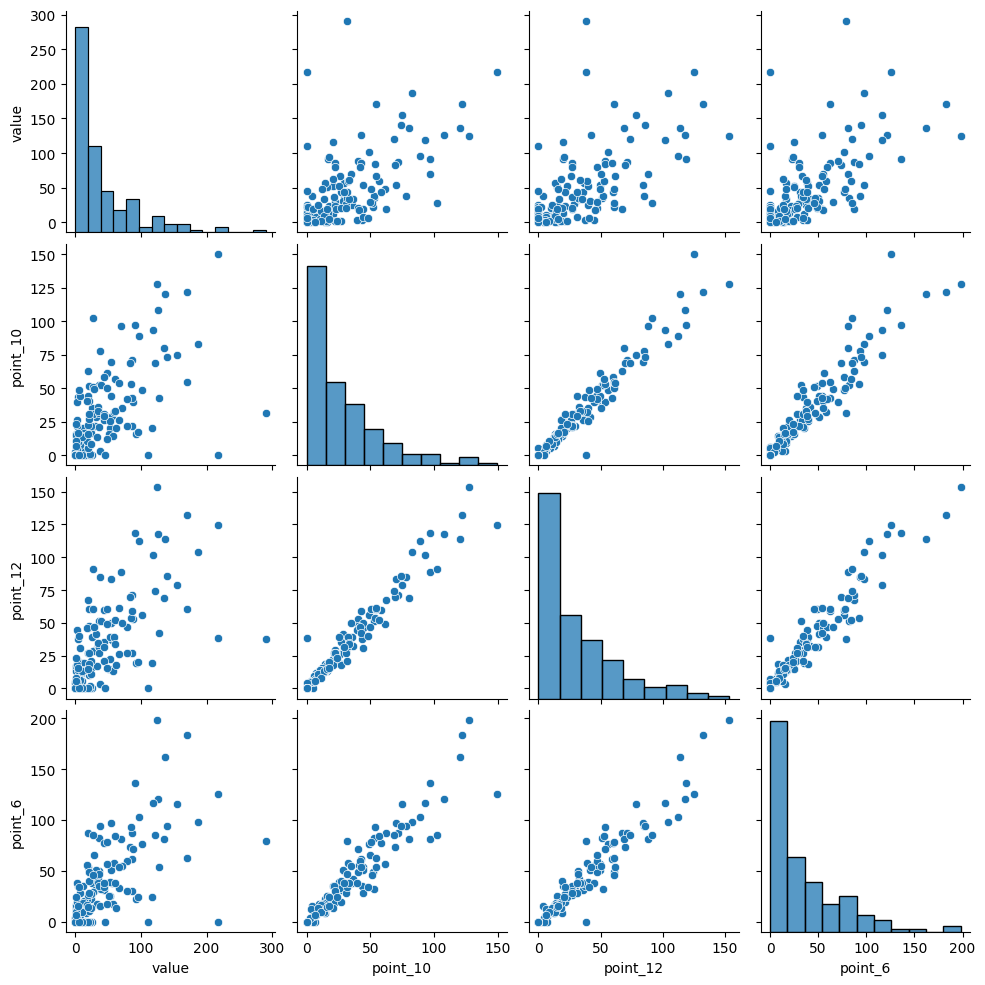

In [15]:
import seaborn as sns 
# Método gráfico de dispersión
sns.pairplot(dataset_no_nan)
# Metodo numerico
dataset_no_nan.corr()

- Matriz de confusion

Con esta analizamos de manera mas legible el estado de las correlaciones que tenemos en el dataset, con esto se analiza la calidad de los datos para la imputacion

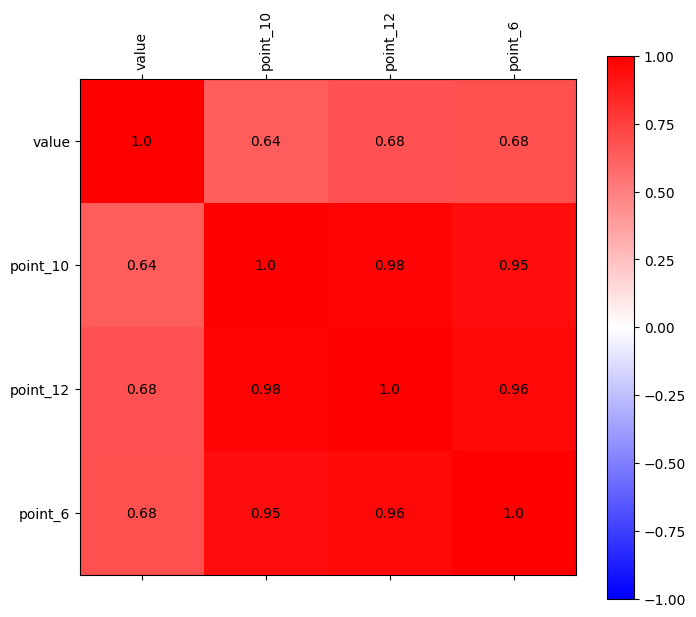

In [16]:
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
matriz = dataset_no_nan.corr()

# Crear la figura de la matriz de correlación
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)

# Configurar etiquetas de los ejes X e Y
plt.xticks(range(len(matriz.columns)), dataset_no_nan.columns, rotation=90)
plt.yticks(range(len(matriz.columns)), dataset_no_nan.columns)

# Agregar los valores de la correlación en cada celda de la matriz
for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2), ha="center", va="center", color="black")

# Agregar barra de colores
plt.colorbar()

# Ajustar el tamaño de la figura
plt.gcf().set_size_inches(8, 7)

# Mostrar la matriz de correlación
plt.show()


## **Imputaicon de datos**
---

- Visualizar el estado inicial del *dataset* en cuestrion de valores nulos  y Nan para tener idea de los rellenos 

In [17]:
dataset.isnull().sum()

value       175
point_10      0
point_12      0
point_6       2
dtype: int64

- Creamos el **dataset_model** variable que contiene las tres series que se van a trabajar en el modelo

- Creamos **fechas_con_datos** la cual contiene el df anterior pero eliminando las filas o registros con datos Nan

In [18]:
#Organizamos un dataframe con tres estaciones (2 estaciones para ser predictoras y 1 para ser predecida)
dataset_model = dataset[["point_10", "point_6", "value"]] #ajuste

#Solo se dejan las filas que tengan datos en las tres estaciones
fechas_con_datos = dataset_model.dropna() #ajuste

dataset_model.head(2)

,point_10,point_6,value
timestamp,,,
2010-01-01,0.0,0.0,0.0
2010-01-02,0.0,0.0,0.0


- usamos el modelo de regresion lineal ajustada a los datos con algunas metricas.

Ecuación de la recta: y = -0.5 * point_10 + 0.91 * point_6 + 3.98
Coeficiente de correlación: 0.3128790913789808
Coeficiente de determinación: 0.166800234544777


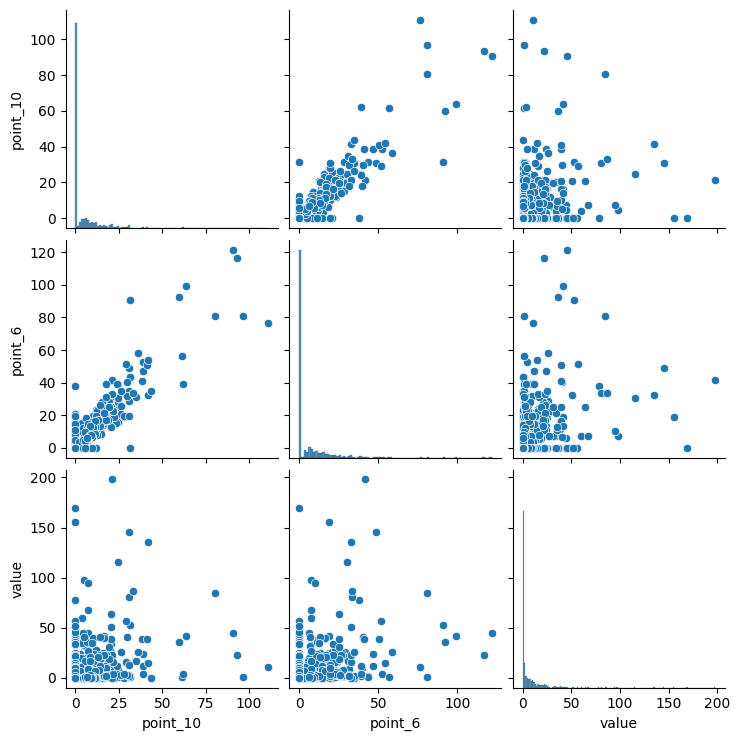

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Definir el modelo de regresión lineal
modelo = LinearRegression()

# Entrenar el modelo con dos variables predictoras
X_train = fechas_con_datos[['point_10', 'point_6']]
y_train = fechas_con_datos['value']
modelo.fit(X_train, y_train)

# Obtener los coeficientes
coef_10 = round(modelo.coef_[0], 2)
coef_6 = round(modelo.coef_[1], 2)
intercept = round(modelo.intercept_, 2)

# Imprimir la ecuación de la recta
print(f'Ecuación de la recta: y = {coef_10} * point_10 + {coef_6} * point_6 + {intercept}')

# Calcular y mostrar el coeficiente de correlación
correlation_matrix = np.corrcoef(fechas_con_datos[['point_10', 'point_6']].T, y_train)
correlation = correlation_matrix[0, 2]  # Correlación entre y_train y la primera variable
print(f'Coeficiente de correlación: {correlation}')

# Calcular y mostrar el coeficiente de determinación (R²)
r2 = r2_score(y_train, modelo.predict(X_train))
print(f'Coeficiente de determinación: {r2}')

# Graficar la relación de las variables con "value"
sns.pairplot(fechas_con_datos, vars=['point_10', 'point_6', 'value'], height=2.5)
plt.show()


- Se crea una predicion de la serie temporal basada en una de las variables completas, para ello se utiliza un escalador para normalizar los datos y redes neuronales para generar el modelo

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))


# Datos
xTrain = fechas_con_datos[["point_10", "point_6"]].values  
yTrain = fechas_con_datos["value"].values  

# Normalización
scaler = MinMaxScaler().fit(xTrain)
xTrainScaled = scaler.transform(xTrain)

# Definir función de construcción del modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=50, max_value=200, step=50), activation='relu', input_shape=(xTrain.shape[1],)))
    model.add(Dense(hp.Int('units_2', min_value=25, max_value=100, step=25), activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compilar el modelo con tasa de aprendizaje ajustable
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])),
                  loss='mse')
    return model

# Configurar la búsqueda de hiperparámetros con Hyperband
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=50,
                     factor=3,
                     directory='tuner_dir',
                     project_name='best_model_search')

# Realizar la búsqueda de hiperparámetros
tuner.search(xTrainScaled, yTrain, epochs=50, validation_split=0.2, verbose=1)

# Obtener los mejores hiperparámetros encontrados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nMejores Hiperparámetros Encontrados:")
print(f"Neuronas capa 1: {best_hps.get('units_1')}")
print(f"Neuronas capa 2: {best_hps.get('units_2')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

# Entrenar el mejor modelo encontrado
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(xTrainScaled, yTrain, epochs=100, validation_split=0.2, verbose=1)

# Evaluar el modelo con datos de prueba
xTest = dataset[["point_10", "point_6"]].dropna().values
xTestScaled = scaler.transform(xTest)
yPredict = best_model.predict(xTestScaled).flatten()

# Convertir predicciones a Serie de Pandas
yPredict_series = pd.Series(yPredict, index=dataset.index[:len(yPredict)])

# Calcular correlación
corr_value = dataset_model["value"].loc[yPredict_series.index].corr(yPredict_series)

# Mostrar resultados
print(f'Correlación: {corr_value:.2f}')
print(f'Media real (yTrain): {yTrain.mean():.2f}')
print(f'Media predicha (yPredict_series): {yPredict_series.mean():.2f}')

# Graficar comparación
plt.figure(figsize=(12, 6))
plt.plot(dataset_model.index, dataset_model["value"], label="Valor real")
plt.plot(yPredict_series.index, yPredict_series, label="Predicción")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.title("Comparación de Valores Reales vs. Predicción (Modelo Óptimo)")
plt.show()


GPUs disponibles: []


NameError: name 'fechas_con_datos' is not defined

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import randint, uniform

# Escalar los datos
scaler = MinMaxScaler().fit(xTrain.values)
xTrainScaled = scaler.transform(xTrain.values)

# Definir el modelo base
regr = MLPRegressor(max_iter=10000, random_state=1)

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    "hidden_layer_sizes": [(50,), (100,), (100, 50), (200, 100)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": uniform(0.0001, 0.01),  # Regularización L2
    "learning_rate_init": uniform(0.001, 0.01),
}

# Realizar búsqueda aleatoria
search = RandomizedSearchCV(
    regr, param_distributions=param_dist, n_iter=20, cv=3, verbose=2, n_jobs=-1
)
search.fit(xTrainScaled, yTrain)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", search.best_params_)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
import plotly.express as px
import pandas as pd

# Crear un DataFrame con los datos reales y predichos
df = pd.DataFrame({
    "Valor": list(yTrain) + list(yPredict_series),
    "Tipo": ["Real"] * len(yTrain) + ["Predicho"] * len(yPredict_series)
})

# Graficar con Plotly
fig = px.histogram(df, x="Valor", color="Tipo", barmode="overlay", 
                   histnorm="probability density", opacity=0.5)

fig.update_layout(title="Distribución de valores reales vs predichos",
                  xaxis_title="Valor", yaxis_title="Densidad",
                  template="plotly_white")

fig.show()


In [ ]:
# Se crea una nueva columna para agregar los datos
dataset_model["value_complet"] = 0 #ajustar
ajuste = dataset_model['value_complet'].mean()-dataset_model['value'].mean()
dataset_model['value_complet']=dataset_model['value_complet']-ajuste
# Agregar los datos en la matriz (se agregan solamente predicciones donde no hay datos observados)
for index, row in dataset_model.iterrows():
    if np.isnan(row["value"]) and ~np.isnan(row["point_10"]) and ~np.isnan(row["point_6"]): #ajustar primer
        rowScaled = scaler.transform([[row["point_10"],row["point_6"]]])
        dataset_model.loc[index,["value_complet"]] = regr.predict(rowScaled) #ajustar 
    elif ~np.isnan(row["value"]): #ajustar
        dataset_model.loc[index,["value_complet"]] = row["value"] #ajustar 
    else:
        row["value_complet"] = np.nan #ajustar

display(dataset_model['value'].mean(), dataset_model['value_complet'].mean())

6.946905537459283

7.061994165728969

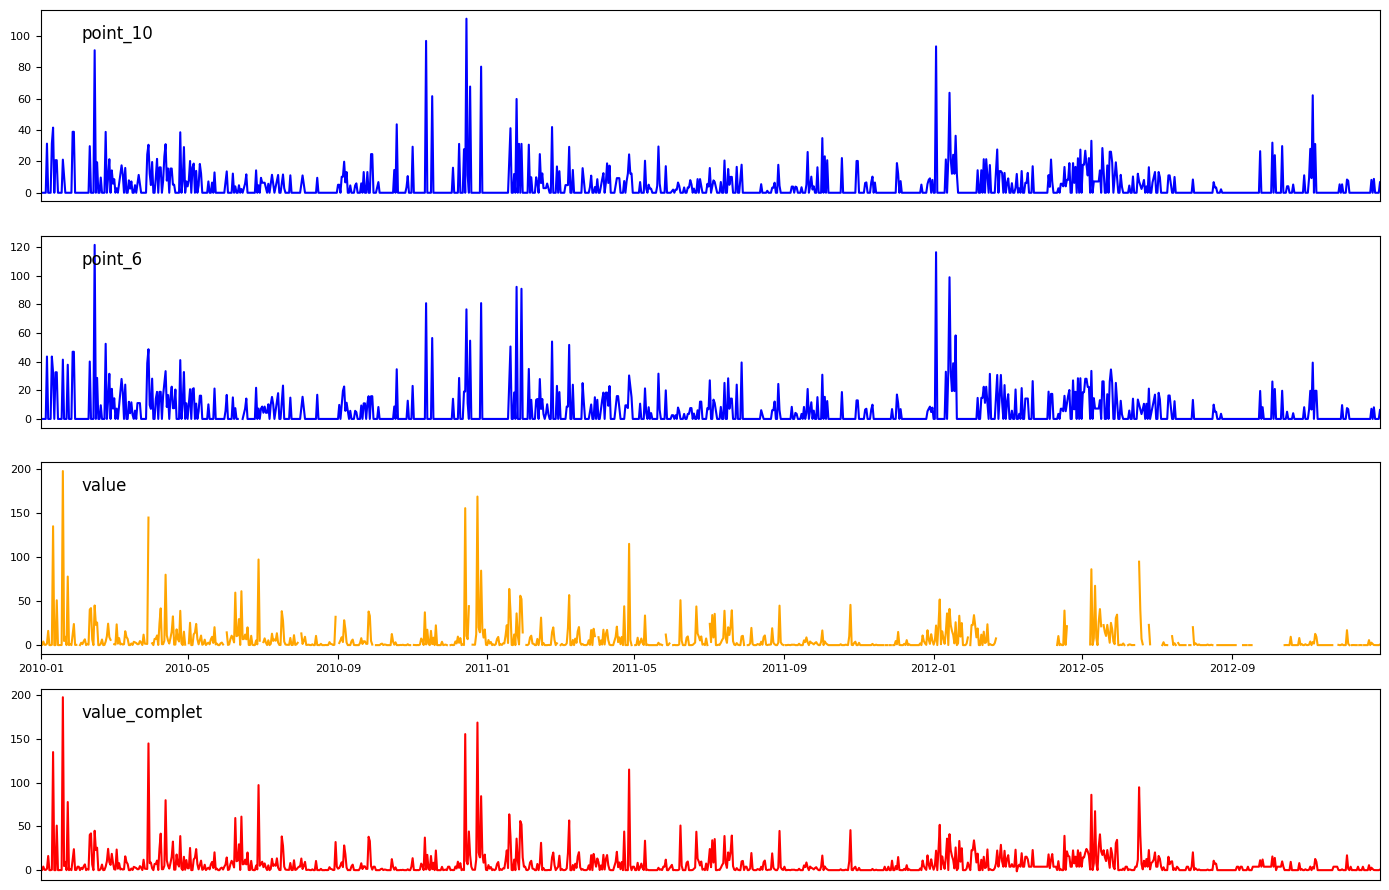

In [ ]:
#Gráfica
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 9)) # Ajustar el número de "nrows" por el número de columnas a gráficar
colores = ['blue', 'blue', 'orange', 'red']
for i, col in enumerate(dataset_model.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset_model.index, dataset_model[col], color=colores[i%len(colores)])
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset_model.index.min(), dataset_model.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
    if i != len(dataset_model.columns[1:]) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('', fontsize=6)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [ ]:
from graphics_utils.go import multi_line

fig = multi_line(original=dataset_model['value'], Recostruccion = dataset_model['value_complet'])
fig.show()